# TIME SERIES

In this notebook we first revise the main utilities of Pandas for managing time series. Afterwards, we will introduce the library *DARTS* of Python to train forecast models and predict with them.

https://unit8co.github.io/darts/


In [1]:
#current version is 0.26.0

!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.8/784.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 13.9 MB/s eta

## A simple example: the *Airline Passengers* dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read a pandas DataFrame
df = pd.read_csv('https://krono.act.uji.es/IDIA/airline-passengers.csv')

df['Month'] = pd.to_datetime(df['Month']) ##inferimos la fecha - se completan los datos faltantes (día)

df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


<Axes: >

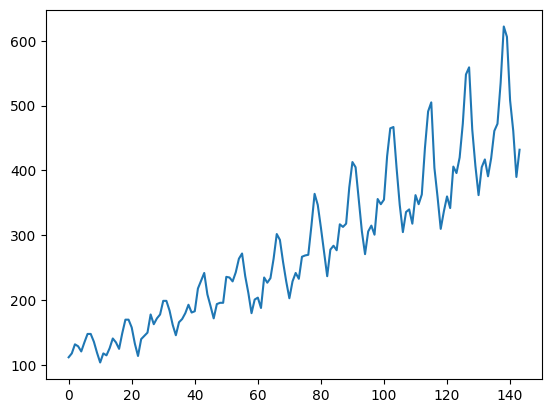

In [3]:
df['Passengers'].plot()

**Exercise 1**: Find out where the maximum peaks are repeated. Can you know what the seasonal months are?

In [ ]:
#

### Missing observations

If the series has missing values, we can obtain them by interpolation. Some forecasting methods are able to deal with missed observations along time (e.g., Prophet).

<Axes: xlabel='Month'>

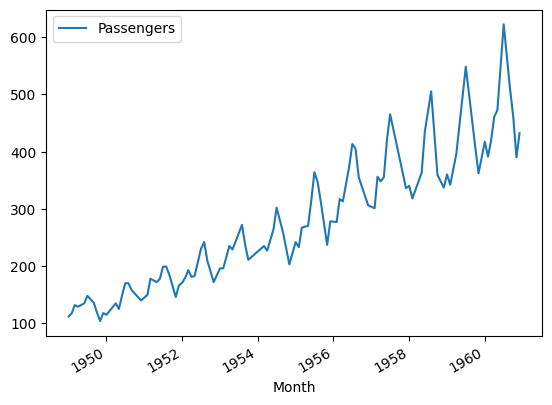

In [4]:
df_missing = df.sample(frac=0.7).set_index('Month')
df_missing.interpolate(method='linear').plot()

### Smoothing provides useful information

Pandas provides a good number of functions to manage time series. As an example, we can resample the series to differnt granularities (M), años (A) o días (D), and specifying periods (xG) for them. The result is the smoothing of the time series, revealing its trend.

<Axes: xlabel='Month'>

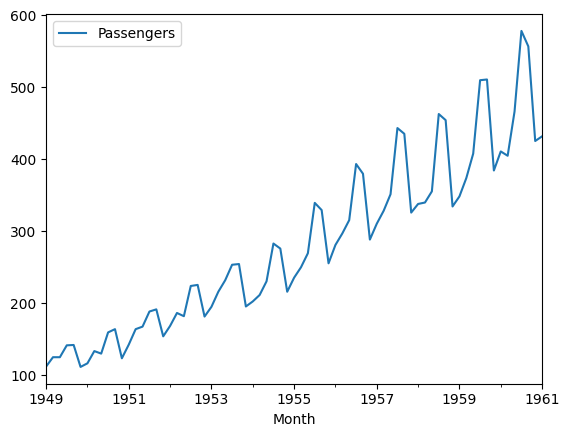

In [5]:
df.set_index('Month').resample('2M').mean().plot()

<Axes: xlabel='Month'>

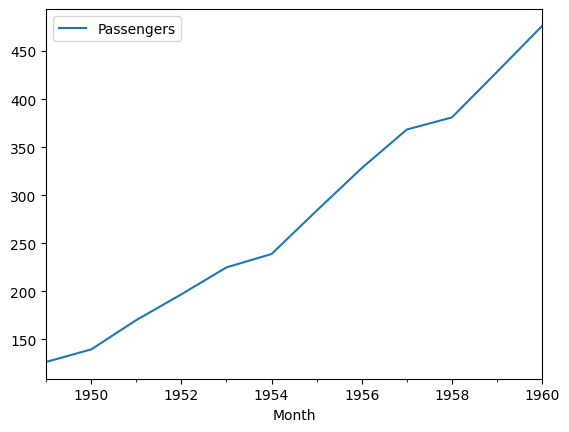

In [6]:
df.set_index('Month').resample('A').mean().plot() #periods of 3 months

The moving average (MA) can smooth the time series to reduce the effect of seasons and noise. Here, *window* is the size of the moving window for performing the **convolution** of the time series. The argument *min_periods* sets the minimum number of observations that must be within the window to perform the average.

<Axes: xlabel='Month'>

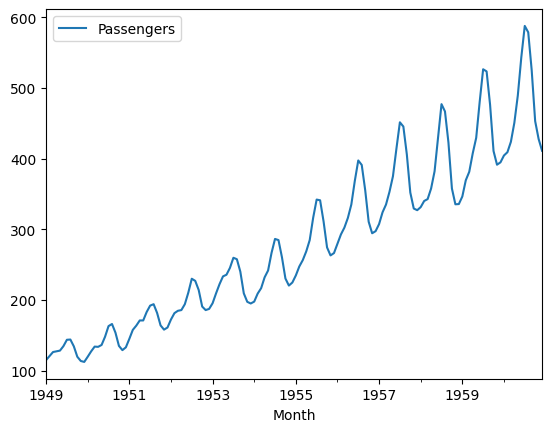

In [7]:
df.set_index('Month').rolling(window=3, center=True, min_periods=1).mean().plot()

## Decomposition of the time series
* Trend
* Cycles
* Seasons
* White noise

In [8]:
#import numpy as np

x = df.index.to_numpy()

p1, res1, _, _ , _ = np.polyfit(x, df['Passengers'], 1, full=True)
p1_fn = np.poly1d(p1)

p2, res2, _, _ , _ = np.polyfit(x, df['Passengers'], 2, full=True)
p2_fn = np.poly1d(p2)

print("Trend (linear):", p1, res1)
print("Trend (quadratic):", p2, res2)

Trend (linear): [ 2.65718391 90.30996169] [301219.11848659]
Trend (quadratic): [7.00819832e-03 1.65501155e+00 1.14028041e+02] [284328.40508941]


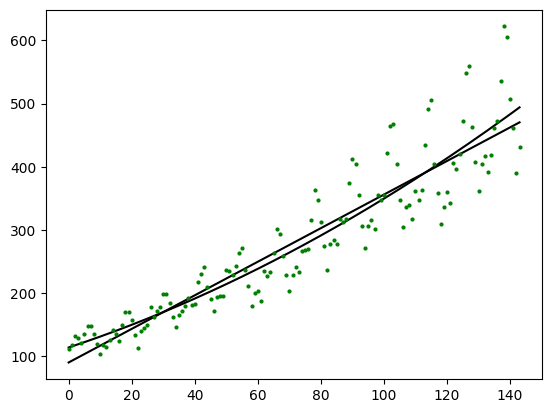

In [9]:
plt.plot(x, p2_fn(x), 'k-')
plt.plot(x, p1_fn(x), 'k-')
plt.plot(x, df['Passengers'], 'go', ms=2)

Auto-correlación: 0.9601946480498523


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

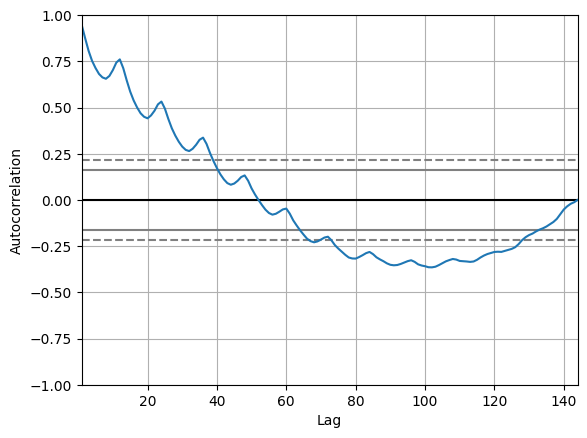

In [10]:
from pandas.plotting import autocorrelation_plot

print('Auto-correlación:', df['Passengers'].autocorr())

autocorrelation_plot(df.set_index('Month')) ##ACF

## NORMALIZING TIME SERIES

There are different ways to get a stationary time series from a non-stationary one. We here revise the most applied ones.

### Method 1: Log of the time series minus rolling mean

Goal: de-trend (by substracting the rolling mean) and eliminate the "multiplicative" effect of the original series (by applying log).

<Axes: xlabel='Month'>

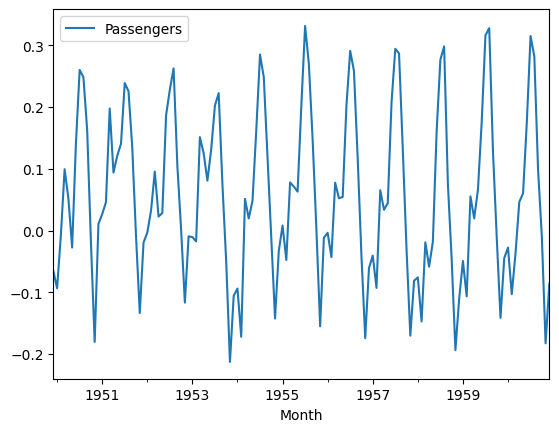

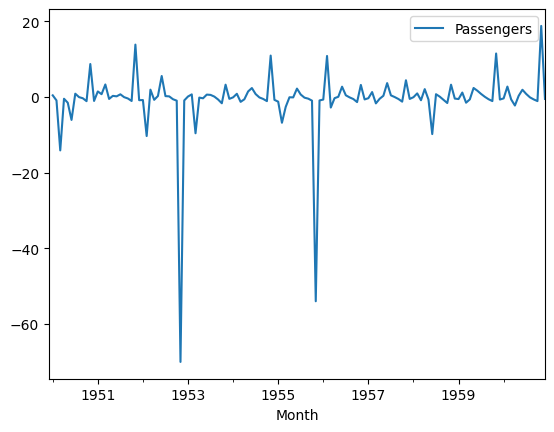

In [11]:
df_log = np.log(df.set_index('Month'))

#restamos la "rolling mean"
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

df_log_minus_mean.plot()
df_log_minus_mean.pct_change(fill_method='ffill').plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

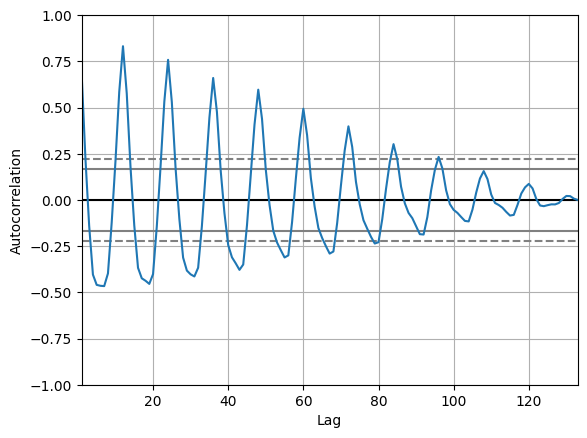

In [12]:
autocorrelation_plot(df_log_minus_mean) ##ACF

### Method 2. Exponential smoothing

Goal: like Method 1 but the moving average is calculated with exponential decay.



<Axes: xlabel='Month'>

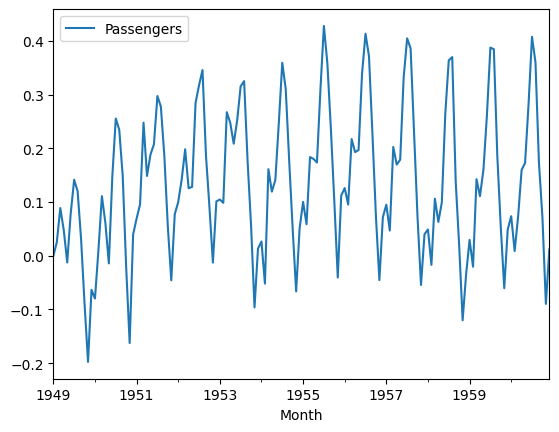

In [13]:
#df_log = np.log(df.set_index('Month'))

rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)

df_log_exp_decay.plot()

### Method 3: Differentiation

Goal: apply the differenation of the series to reduce the seasonability effect.

<Axes: xlabel='Month'>

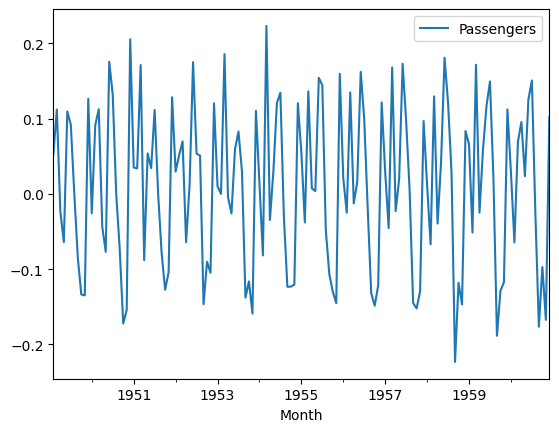

In [14]:
#df_log = np.log(df.set_index('Month'))

df_log_shift = df_log.diff()
df_log_shift.dropna(inplace=True)

df_log_shift.plot()

In the **DARTS** library you can find other transformers and their inverses to improve forecasting. The following link shows some examples of normalizations along with their inverses (to get back the original time series scale, once values are predicted):

https://unit8co.github.io/darts/examples/02-data-processing.html

## Frequency Analysis with Fast Fourier Transform

Which are the dominant frequencies in the time series? Which cycles the time series contain?

(We use for this part the library **scipy**)

In [15]:
import scipy as sp
import scipy.fftpack

temp_fft = sp.fftpack.fft(df['Passengers']) #_log_minus_mean)
temp_psd = np.abs(temp_fft) ** 2

print(temp_psd.shape)

(144,)


In [16]:
freq_unit = 1/12 #months

fftfreq = sp.fftpack.fftfreq(len(temp_psd), freq_unit)

i = fftfreq > 0

Text(0, 0.5, 'PSD')

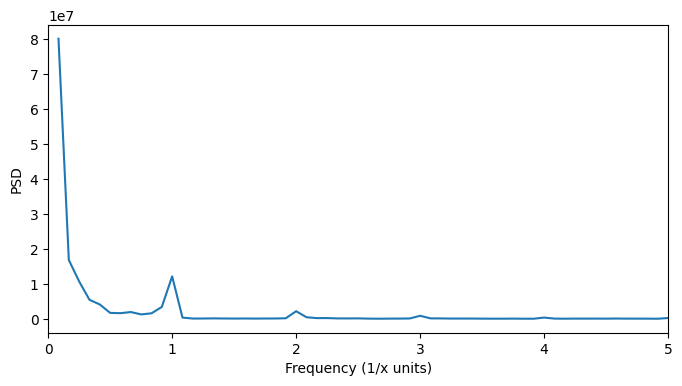

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], temp_psd[i])
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/x units)')
ax.set_ylabel('PSD')


## TRAINING AND PREDICTING WITH FORECAST MODELS

We will first use a simple model named *Exponential Smoothing*

https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572


In [3]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing

In [4]:
df_log = np.log(df.set_index('Month'))

#restamos la "rolling mean"
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

#df_log_minus_mean.index.name = 'Month'
df_log_minus_mean['Month'] = df_log_minus_mean.index
df_log_minus_mean.head()


,Passengers,Month
Month,,
1949-12-01,-0.065494,1949-12-01
1950-01-01,-0.093449,1950-01-01
1950-02-01,-0.007566,1950-02-01
1950-03-01,0.099416,1950-03-01
1950-04-01,0.052142,1950-04-01


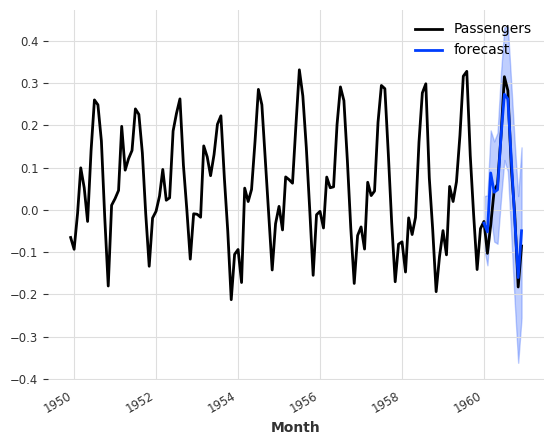

In [5]:
# Create a TimeSeries, specifying the time and value columns (it can be a list)

series = TimeSeries.from_dataframe(df_log_minus_mean, time_col='Month', value_cols='Passengers')

# Split the series into train and validation (you can use the utility train_test_split from DARTS)

train, val = series[:-12], series[-12:]

# Build and train the model

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

# Visualize the prediction

series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

### The `TimeSeries` object

Prediction is an object of the class `TimeSeries`

https://unit8co.github.io/darts/generated_api/darts.timeseries.html

Values of the predicted time series are stored in a special array with the following components: *(time, dimensions, samples)*

Dimensions are the time serires that we included in the `value_cols` argument (it can be a list)

Predictions can be "stochastic" if it is a random process that generates a number of samples, or "deterministic" if the result is just one time series.

Implementation has been done with Xarrays: https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html

In [44]:
prediction

<TimeSeries (DataArray) (Month: 12, component: 1, sample: 1000)>
array([[[ 0.0357026 , -0.01470333,  0.00667948, ..., -0.02601098,
         -0.07190472, -0.04272701]],

       [[ 0.03422884, -0.00374054, -0.03094882, ..., -0.04217635,
         -0.13612701, -0.11319765]],

       [[ 0.1183809 ,  0.07379435,  0.11156095, ...,  0.09151764,
         -0.04013363,  0.02462838]],

       ...,

       [[ 0.25027823,  0.03636204, -0.08639756, ..., -0.05750786,
         -0.15449575, -0.04374003]],

       [[ 0.10227156, -0.13496892, -0.16286527, ..., -0.20216236,
         -0.25739939, -0.17763108]],

       [[ 0.2205648 , -0.02203901, -0.0247585 , ..., -0.16037021,
         -0.14296727, -0.05374207]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1960-01-01 1960-02-01 ... 1960-12-01
  * component  (component) object 'Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

To get one of the samples from the prediction, we must indicate the time slice, component and position of the sample starting in 0.

In [45]:
prediction.all_values()[:,0,50]

array([-0.06258613, -0.11121388, -0.03905677, -0.06993387, -0.13101047,
        0.02655679,  0.12139451,  0.16626699,  0.11461954, -0.01729411,
       -0.12904685, -0.07335651])

We can also extract one series representing the predicted samples, like the median:

<Axes: xlabel='Month'>

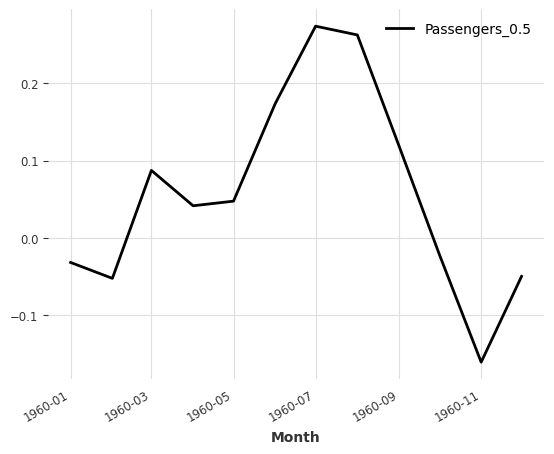

In [46]:
prediction.quantile_timeseries(0.5).plot()

The extracted series can be then processed by converting it to a Pandas series as follows:

In [47]:
prediction.quantile_timeseries(0.5).pd_series()

Month
1960-01-01   -0.031637
1960-02-01   -0.052149
1960-03-01    0.087294
1960-04-01    0.041612
1960-05-01    0.047574
1960-06-01    0.173613
1960-07-01    0.273643
1960-08-01    0.262307
1960-09-01    0.118723
1960-10-01   -0.021599
1960-11-01   -0.160427
1960-12-01   -0.049612
Freq: MS, dtype: float64

You can also convert the extracted series to a Pandas dataframe:

In [48]:
prediction.quantile_timeseries().pd_dataframe()

component,Passengers_0.5
Month,
1960-01-01,-0.031637
1960-02-01,-0.052149
1960-03-01,0.087294
1960-04-01,0.041612
1960-05-01,0.047574
1960-06-01,0.173613
1960-07-01,0.273643
1960-08-01,0.262307
1960-09-01,0.118723


### RESIDUALS ANALYSIS

Be patient! this operation is time consuming.

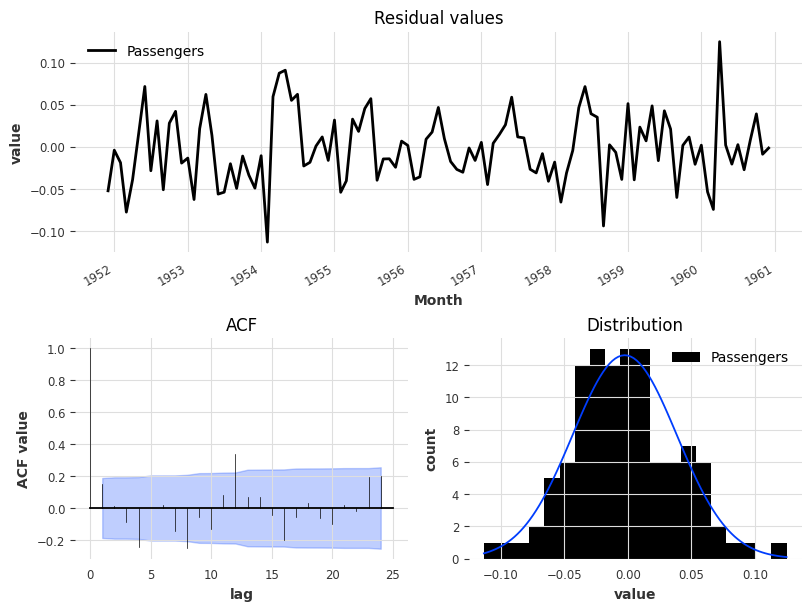

In [53]:
from darts.utils.statistics import *

residuals = model.residuals(series)

plot_residuals_analysis(residuals)

### EVALUATE THE MODEL

DARTS provides us a good number of metrics to evaluate the prediction.

https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html

In [6]:
from darts.metrics import mape, rmse

In [9]:
import numpy as np

In [21]:
prediction_exp = prediction.map(np.exp)  # Aplicar la función exponencial

# Sumar la media móvil exponencial nuevamente (rolling_mean)
# prediction_final = prediction_exp + rolling_mean.iloc[-12:]  # Tomar los últimos 12 valores de la media móvil exponencial y sumarlos

In [22]:
print('MAPE = ', mape(val, prediction_exp))
print("RMSE = ", rmse(val, prediction_exp))

MAPE =  2191.7804984657973
RMSE =  1.0240415185611356


In [28]:
from darts.models import Prophet

We train and evaluate a PROPHET model.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyjrj7b2f/4lhb86_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyjrj7b2f/ahh957ja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6226', 'data', 'file=/tmp/tmpyjrj7b2f/4lhb86_3.json', 'init=/tmp/tmpyjrj7b2f/ahh957ja.json', 'output', 'file=/tmp/tmpyjrj7b2f/prophet_model0kojj2cn/prophet_model-20231002174858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


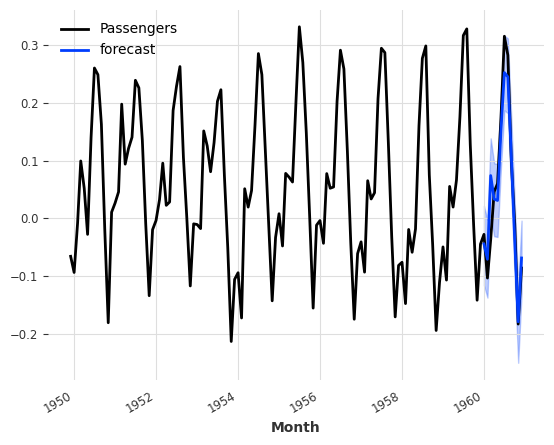

In [51]:
model2 = Prophet()
model2.fit(train)
prediction = model2.predict(len(val), num_samples=1000)


series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()


In [52]:
print('MAPE = ', mape(val, prediction))
print("RMSE = ", rmse(val, prediction))

MAPE =  69.44853614333515
RMSE =  0.042301073601490345


## Anomaly detection

In [31]:
import darts.ad.detectors.quantile_detector as qad

Anomaly = qad.QuantileDetector(low_quantile=0.05, high_quantile=0.95)

Anomaly.fit(train)

Anomaly.detect(val).pd_series()

Month
1960-01-01    0.0
1960-02-01    0.0
1960-03-01    0.0
1960-04-01    0.0
1960-05-01    1.0
1960-06-01    1.0
1960-07-01    1.0
1960-08-01    1.0
1960-09-01    1.0
1960-10-01    0.0
1960-11-01    0.0
1960-12-01    0.0
Freq: MS, dtype: float64

In [32]:
print("Anomalies detected:", Anomaly.fit_detect(series).pd_series().sum())

Anomalies detected: 16.0


In [33]:
norm_series = TimeSeries.from_dataframe(df_log_minus_mean.reset_index(), time_col='Month', value_cols='Passengers')

print("Anomalies detected:", Anomaly.fit_detect(norm_series).pd_series().sum())

Anomalies detected: 14.0
